<CENTER><img src="../images/opendata-top-transblack.png" style="width:40%"></CENTER>

<CENTER><h1>Simple pyROOT notebook example using TLorentz Vectors</h1></CENTER>

In [1]:
import ROOT

Welcome to JupyROOT 6.14/04


In [2]:
## f = ROOT.TFile.Open("mc_105986.ZZ.root")
## f = ROOT.TFile.Open("mc_147770.Zee.root")
f = ROOT.TFile.Open("/project/etp3/nhartmann/opendata/MC/mc_147770.Zee.root")

In [3]:
c = ROOT.TCanvas("testCanvas","a first way to plot a variable",800,600)

In [4]:
t = f.Get("mini")

In [5]:
t.GetEntries()

7500000L

In [6]:
h = ROOT.TH1F("variable","Example plot: Number of Leptons",4,0,4)

In [7]:
h_Mll = ROOT.TH1F("h_Mll","Invariant mass of the two Leptons",50,0,200)

In [8]:
%%time
w = 1
for i, event in enumerate(t):
    """This is the cut #1: request at least 2 leptons"""
    if not (i%10000):
        print("Processing event {}".format(i))
    if t.lep_n > 1:
        """Let's define one TLorentz vector for each, e.i. two vectors!"""
        leadingLep = ROOT.TLorentzVector(t.lep_pt[0], t.lep_eta[0], t.lep_phi[0], t.lep_E[0])
        secondLep  = ROOT.TLorentzVector(t.lep_pt[1], t.lep_eta[1], t.lep_phi[1], t.lep_E[1])

        """Next line does the addition of the two TLorentz vectors above and so,
           we can ask the mass very easy"""
        TL_ll = leadingLep + secondLep
        
        """We devide the value of the combined vector by 1000 to get the value in GeV"""
        mll = TL_ll.M()/1000.
        h_Mll.Fill(mll,w)
        
    if i > 100000:
        print("Stopping - this is too slow in python")
        break

print "Done!"

Processing event 0
Processing event 10000
Processing event 20000
Processing event 30000
Processing event 40000
Processing event 50000
Processing event 60000
Processing event 70000
Processing event 80000
Processing event 90000
Processing event 100000
Stopping - this is too slow in python
Done!
CPU times: user 5.31 s, sys: 195 ms, total: 5.51 s
Wall time: 4.95 s


# Let c++ do the hard work

There are many ways to interface c++ with python. We will just write a simple ROOT macro and execute it via pyroot.

In [9]:
%%writefile fill_mll.C

#include <iostream>
#include "TTree.h"
#include "TH1.h"
#include "TLorentzVector.h"

void fill_mll(TTree* tree, TH1F* hist) {

    UInt_t  lep_n;      //number of preselected leptons
    Float_t lep_pt[5],      //transverse momentum of the lepton
            lep_charge[5],  //charge of the lep
            lep_eta[5],     //pseudorapidity of the lepton
            lep_phi[5],     //azimuthal angle of the lepton
            lep_E[5];       //energy of the lepton
    
    // Just read nescessary branches
    tree->SetBranchAddress("lep_pt", &lep_pt);
    tree->SetBranchAddress("lep_eta", &lep_eta);
    tree->SetBranchAddress("lep_phi", &lep_phi);
    tree->SetBranchAddress("lep_E", &lep_E);
    tree->SetBranchAddress("lep_n", &lep_n);
    
    tree->SetBranchStatus("*", 0);
    tree->SetBranchStatus("lep_n", 1);
    tree->SetBranchStatus("lep_pt", 1);
    tree->SetBranchStatus("lep_eta", 1);
    tree->SetBranchStatus("lep_phi", 1);
    tree->SetBranchStatus("lep_E", 1);
    
    TLorentzVector leadinglep, secondlep;
    
    for (int i=0; i<tree->GetEntriesFast(); i++) {
        tree->GetEntry(i);
        if (!(i%1000000)) {
            std::cout << "Processing event " << i << std::endl;
        }
        leadinglep.SetPtEtaPhiE(lep_pt[0], lep_eta[0], lep_phi[0], lep_E[0]);
        secondlep.SetPtEtaPhiE(lep_pt[1], lep_eta[1], lep_phi[1], lep_E[1]);
        hist->Fill((leadinglep+secondlep).M()/1000.);
    }
}

Overwriting fill_mll.C


In [9]:
# load the c++ function
ROOT.gROOT.ProcessLine(".L fill_mll.C+")

0L

In [10]:
%%time
h_Mll.Reset()
ROOT.fill_mll(t, h_Mll)

CPU times: user 5.09 s, sys: 153 ms, total: 5.24 s
Wall time: 5.24 s
Processing event 0
Processing event 1000000
Processing event 2000000
Processing event 3000000
Processing event 4000000
Processing event 5000000
Processing event 6000000
Processing event 7000000


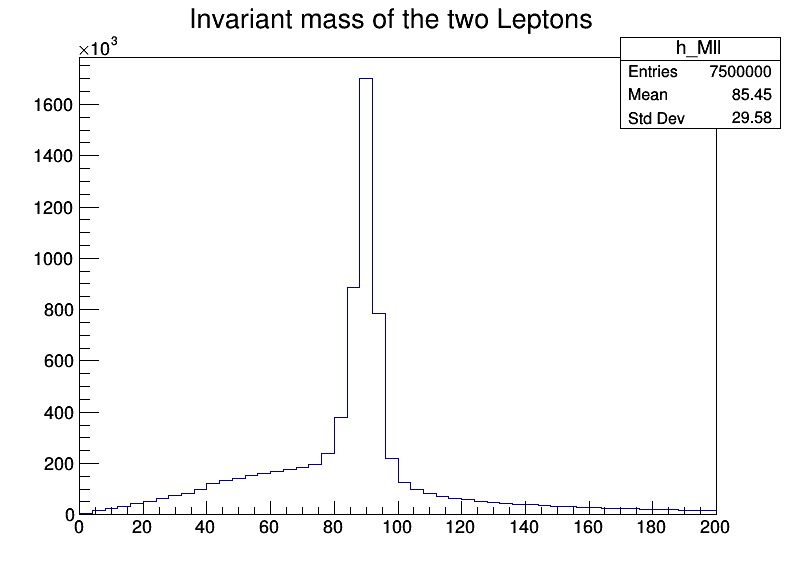

In [12]:
h_Mll.Draw()
c.Draw()